In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
import statistics

In [2]:
data_file = pd.read_csv('undergrad_takehome_2020.csv')
data_file.head()

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
0,1,1,TX,48628171.02,9218156.69,24278189.23,365880,4452,False
1,1,2,TX,48107179.24,10587747.35,25116844.41,365880,4452,False
2,1,3,TX,64352278.29,10193873.77,33703499.83,365880,4452,False
3,1,4,TX,45943677.96,8764165.00,24037719.47,365880,4452,False
4,1,5,TX,32761434.98,8022116.43,16432119.18,365880,4452,False


# PART 1 - SUMMARY STATISTICS AND PLOTS

In [3]:
#Calculate annual profit margin
data_file['Monthly profit'] = data_file['Gross revenue'] - data_file['Fixed cost'] - data_file['Variable cost'] - data_file['Rental cost']
annual_profit = pd.DataFrame(data_file.groupby('Location number').agg({'Gross revenue' : 'sum',
                                                                       'Monthly profit' : 'sum'}))
annual_profit = annual_profit.rename(columns={'Monthly profit': 'Annual profit'})
annual_profit['Annual profit margin'] = annual_profit['Annual profit'] / annual_profit['Gross revenue'] * 100
annual_profit.head()

,Gross revenue,Annual profit,Annual profit margin
Location number,,,
1,5.447389e+08,1.500840e+08,27.551553
2,3.559730e+08,8.858672e+07,24.885798
3,3.317718e+08,8.264618e+07,24.910550
4,2.639843e+08,5.494349e+07,20.813164
5,1.890016e+08,3.960178e+07,20.953145


In [4]:
#Calculate summary statistics
mean = float(annual_profit['Annual profit margin'].mean())
median = float(annual_profit['Annual profit margin'].median())
max_ = float(annual_profit['Annual profit margin'].max())
min_ = float(annual_profit['Annual profit margin'].min())
std = float(annual_profit['Annual profit margin'].std())

#Print summary statistics
print('Mean annual profit margin across stores: ' + str(mean))
print('Median annual profit margin across stores: ' + str(median))
print('Max annual profit margin across stores: ' + str(max_))
print('Min annual profit margin across stores: ' + str(min_))
print('Standard deviation of annual profit margin across stores: ' + str(std))


Mean annual profit margin across stores: 24.863229256707513
Median annual profit margin across stores: 26.184928404393776
Max annual profit margin across stores: 40.20229113235824
Min annual profit margin across stores: -1.0842243565974479
Standard deviation of annual profit margin across stores: 6.2473939936289575


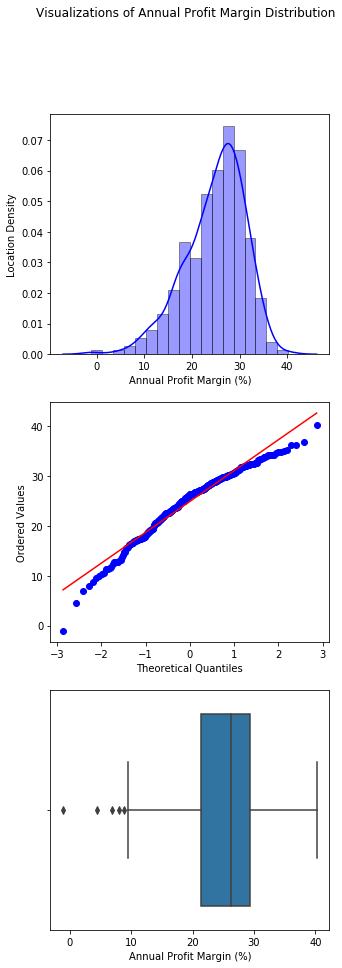

In [5]:
#Create plot
fig, axes = plt.subplots(3, 1, figsize=(5,15))

#Histogram distribution
sns.distplot(annual_profit['Annual profit margin'], hist=True, kde=True, 
             bins='auto', color = 'blue',
             hist_kws={'edgecolor':'black'},
             ax=axes[0])
#Probability plot
probplot(annual_profit['Annual profit margin'], plot=axes[1])
#Box plot
sns.boxplot(annual_profit['Annual profit margin'],ax=axes[2])

#Set labels
fig.suptitle('Visualizations of Annual Profit Margin Distribution')
axes[0].set(xlabel='Annual Profit Margin (%)', ylabel='Location Density')
axes[1].set(title='',xlabel='Theoretical Quantiles', ylabel='Ordered Values')
axes[2].set(xlabel='Annual Profit Margin (%)')

#Show and save plot
plt.savefig('Visualizations of Annual Profit Margin Distribution.png')
plt.show()

Clearly annual profit margins are not normally distributed. In each of the Histogram, Probability Plot, and Box Plot we see that the data is left skewed i.e. less than the mean and median.

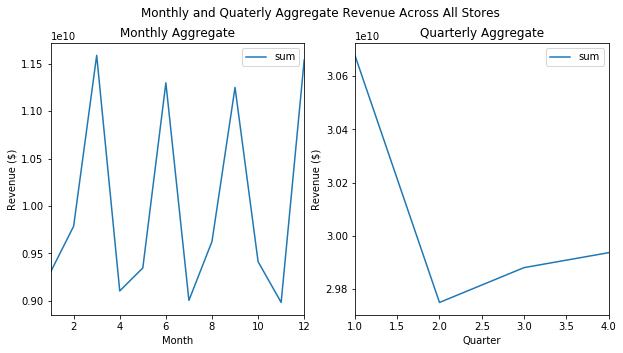

In [6]:
#Aggregate revenue
monthly_agg = pd.DataFrame(data_file.groupby('Month')['Gross revenue'].agg(['sum']))
data_file['Quarter'] = data_file['Month'].apply(lambda month: (month+2)//3)
quarterly_agg = pd.DataFrame(data_file.groupby('Quarter')['Gross revenue'].agg(['sum']))

#Create plot
fig, axes = plt.subplots(1,2, figsize = (10,5))
monthly_agg.plot(ax=axes[0])
quarterly_agg.plot(ax=axes[1])

#Set labels
fig.suptitle('Monthly and Quaterly Aggregate Revenue Across All Stores')
axes[0].set(title = 'Monthly Aggregate',xlabel='Month', ylabel='Revenue ($)')
axes[1].set(title = 'Quarterly Aggregate',xlabel='Quarter', ylabel='Revenue ($)')

#Show plot
plt.savefig('Monthly and Quarterly Aggregate Revenues.png')
plt.show()

# PART 2 - CLEANING THE DATA

In [7]:
#To impute rental cost for owned location, use  median of locations in same state.
rented_locations = data_file.loc[data_file['Owned'] == False]
owned_locations = data_file.loc[data_file['Owned'] == True]
state_agg = pd.DataFrame(rented_locations.groupby('State')['Rental cost'].agg(['median']))
state_median_dict = state_agg['median'].to_dict()
state_median_dict

{'CA': 139615,
 'CO': 135750,
 'GA': 134910,
 'IL': 140265,
 'NJ': 146390,
 'TX': 140660,
 'WA': 174150}

In [8]:
#Fill in costs for owned locations
cleaned_data = data_file.copy()
cleaned_data.loc[cleaned_data['Owned'] == True, 'Rental cost'] = cleaned_data.loc[cleaned_data['Owned'] == True].apply(lambda row: state_median_dict[row['State']],axis=1)
cleaned_data['Monthly profit'] = cleaned_data['Gross revenue'] - cleaned_data['Fixed cost'] - cleaned_data['Variable cost'] - cleaned_data['Rental cost']
cleaned_data = cleaned_data.rename(columns={'Monthly profit' : 'Rent-adjusted monthly profit'})
cleaned_data.head()

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,Rent-adjusted monthly profit,Quarter
0,1,1,TX,48628171.02,9218156.69,24278189.23,365880,4452,False,14765945.10,1
1,1,2,TX,48107179.24,10587747.35,25116844.41,365880,4452,False,12036707.48,1
2,1,3,TX,64352278.29,10193873.77,33703499.83,365880,4452,False,20089024.69,1
3,1,4,TX,45943677.96,8764165.00,24037719.47,365880,4452,False,12775913.49,2
4,1,5,TX,32761434.98,8022116.43,16432119.18,365880,4452,False,7941319.37,2


In [9]:
#Recalculate rent-adjusted annual profit margin
agg_dict = {
    'State' : 'first',
    'Gross revenue' : 'sum',
    'Fixed cost' : 'sum',
    'Variable cost' : 'sum',
    'Rental cost' : 'sum',
    'Number of products' : 'first',
    'Owned' : 'first',
    'Rent-adjusted monthly profit' : 'sum'
}
cleaned_annual_profit = pd.DataFrame(cleaned_data.groupby('Location number').agg(agg_dict))
cleaned_annual_profit = cleaned_annual_profit.rename(columns={'Rent-adjusted monthly profit' : 'Rent-adjusted annual profit'})
cleaned_annual_profit['Rent-adjusted annual profit margin'] = cleaned_annual_profit['Rent-adjusted annual profit'] / cleaned_annual_profit['Gross revenue'] * 100
cleaned_annual_profit['Fixed cost ratio'] = cleaned_annual_profit['Fixed cost'] / cleaned_annual_profit['Gross revenue'] * 100
cleaned_annual_profit['Variable cost ratio'] = cleaned_annual_profit['Variable cost'] / cleaned_annual_profit['Gross revenue'] * 100
cleaned_annual_profit['Rental cost ratio'] = cleaned_annual_profit['Rental cost'] / cleaned_annual_profit['Gross revenue'] * 100

cleaned_annual_profit.head()

,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,Rent-adjusted annual profit,Rent-adjusted annual profit margin,Fixed cost ratio,Variable cost ratio,Rental cost ratio
Location number,,,,,,,,,,,,
1,TX,5.447389e+08,1.108956e+08,2.793687e+08,4390560,4452,False,1.500840e+08,27.551553,20.357566,51.284887,0.805994
2,TX,3.559730e+08,7.287395e+07,1.937291e+08,783240,4502,False,8.858672e+07,24.885798,20.471762,54.422412,0.220028
3,IL,3.317718e+08,6.429775e+07,1.848279e+08,1683180,4620,True,8.096300e+07,24.403219,19.380112,55.709338,0.507331
4,GA,2.639843e+08,6.410409e+07,1.432398e+08,1696920,4481,False,5.494349e+07,20.813164,24.283296,54.260728,0.642811
5,NJ,1.890016e+08,4.475050e+07,1.037553e+08,894000,4533,False,3.960178e+07,20.953145,23.677312,54.896531,0.473012


# PART 3 - QUANTIFY DRIVERS OF SUCCESS

In [10]:
#Initial inquiry -- what characteristics are exhibited by top 5 performers vs. bottom  performers?
bottom_annual_performers = cleaned_annual_profit.sort_values(by=['Rent-adjusted annual profit margin'],ascending = True).head()
top_annual_performers = cleaned_annual_profit.sort_values(by=['Rent-adjusted annual profit margin'],ascending = False).head()
top_annual_performers

,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,Rent-adjusted annual profit,Rent-adjusted annual profit margin,Fixed cost ratio,Variable cost ratio,Rental cost ratio
Location number,,,,,,,,,,,,
198,WA,2.699811e+08,5.340702e+07,1.058644e+08,2171040,4694,False,1.085386e+08,40.202291,19.781766,39.211798,0.804145
233,TX,5.602164e+08,9.715260e+07,2.573850e+08,62400,4778,False,2.056164e+08,36.703036,17.341976,45.943849,0.011139
118,TX,9.660039e+08,1.499075e+08,4.630773e+08,3715680,4726,False,3.493035e+08,36.159635,15.518307,47.937414,0.384644
9,CA,8.129180e+08,1.403155e+08,3.780220e+08,1675380,4789,True,2.929051e+08,36.031328,17.260717,46.501860,0.206095
271,TX,2.665627e+08,5.226988e+07,1.197077e+08,1114440,4637,False,9.347064e+07,35.065163,19.608849,44.907910,0.418078


In [11]:
bottom_annual_performers

,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,Rent-adjusted annual profit,Rent-adjusted annual profit margin,Fixed cost ratio,Variable cost ratio,Rental cost ratio
Location number,,,,,,,,,,,,
157,WA,8.023632e+07,3.079132e+07,4.931738e+07,997560,3810,False,-8.699418e+05,-1.084224,38.375789,61.465158,1.243277
313,CA,3.239651e+08,1.112082e+08,1.961109e+08,2239200,4074,False,1.440679e+07,4.447021,34.327220,60.534573,0.691186
126,NJ,1.447712e+08,4.820199e+07,8.525481e+07,1393800,4218,False,9.920615e+06,6.852616,33.295286,58.889338,0.962760
288,NJ,1.574390e+08,5.104519e+07,9.219930e+07,1546200,4231,False,1.264828e+07,8.033767,32.422206,58.561932,0.982095
111,GA,1.801838e+08,5.445085e+07,1.087970e+08,1040160,4300,False,1.589575e+07,8.821963,30.219621,60.381139,0.577277


In [12]:
#Quintile investigation of cost ratios
cleaned_annual_profit['quintile'] = pd.qcut(cleaned_annual_profit['Rent-adjusted annual profit margin'], 5, labels=False)
median_profit_margins_quintile = []
median_fc_ratio_quintile = []
median_vc_ratio_quintile = []
median_rc_ratio_quintile = []
median_products_quintile = []
for quintile in range(5):
    median_profit_margins_quintile.append(cleaned_annual_profit.loc[cleaned_annual_profit['quintile']==quintile]['Rent-adjusted annual profit margin'].median())
    median_fc_ratio_quintile.append(cleaned_annual_profit.loc[cleaned_annual_profit['quintile']==quintile]['Fixed cost ratio'].median())
    median_vc_ratio_quintile.append(cleaned_annual_profit.loc[cleaned_annual_profit['quintile']==quintile]['Variable cost ratio'].median())
    median_rc_ratio_quintile.append(cleaned_annual_profit.loc[cleaned_annual_profit['quintile']==quintile]['Rental cost ratio'].median())
    median_products_quintile.append(cleaned_annual_profit.loc[cleaned_annual_profit['quintile']==quintile]['Number of products'].median())
    
print('Median profit margins at each quintile: ' + str(median_profit_margins_quintile))
print('Median fixed cost ratio at each profit margin quintile: ' + str(median_fc_ratio_quintile))
print('Median variable cost ratio at each profit margin quintile: ' + str(median_vc_ratio_quintile))
print('Median rental cost ratio at each profit margin quintile: ' + str(median_rc_ratio_quintile))
print('Median number of products at each profit margin quintile: ' + str(median_products_quintile))

Median profit margins at each quintile: [16.698637152553964, 22.499681133870595, 26.018312192896236, 28.596600066973696, 31.832102061769874]
Median fixed cost ratio at each profit margin quintile: [27.076823917922475, 22.929459277176488, 21.30223185808406, 20.095696207996227, 18.206526240362763]
Median variable cost ratio at each profit margin quintile: [56.90884825287967, 54.474250362289624, 52.396376496317664, 50.93295080195254, 49.28508389649798]
Median rental cost ratio at each profit margin quintile: [0.7055644230047567, 0.6364007311619617, 0.5343696882980837, 0.5256518929907559, 0.40401221819256655]
Median number of products at each profit margin quintile: [4350.0, 4465.0, 4536.0, 4554.5, 4635.0]


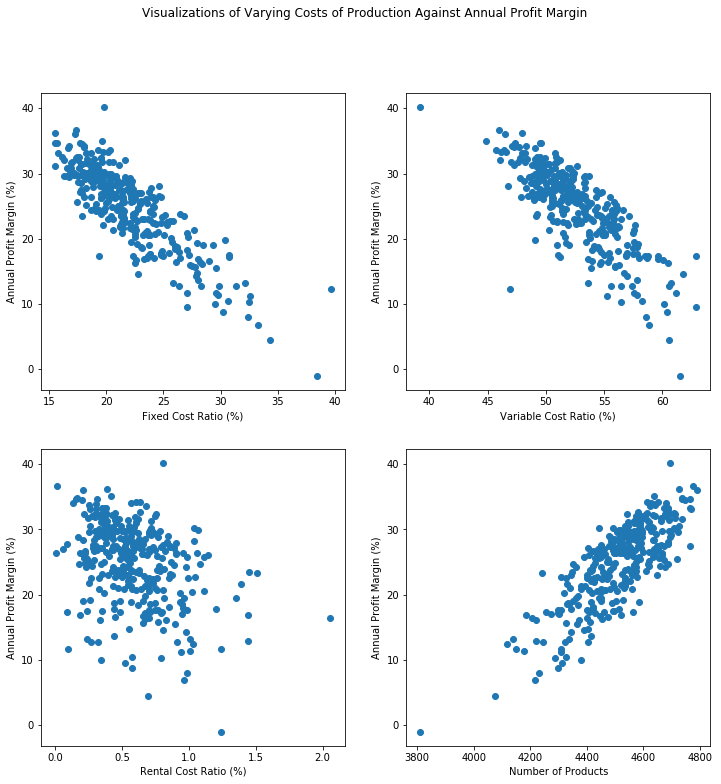

In [13]:
#Visualization of varying costs of production and their relationship with profit margin
#Create plot
fig, axes = plt.subplots(2,2, figsize = (12,12))
#Create scatters
axes[0,0].scatter(cleaned_annual_profit['Fixed cost ratio'], cleaned_annual_profit['Rent-adjusted annual profit margin'])
axes[0,1].scatter(cleaned_annual_profit['Variable cost ratio'], cleaned_annual_profit['Rent-adjusted annual profit margin'])
axes[1,0].scatter(cleaned_annual_profit['Rental cost ratio'], cleaned_annual_profit['Rent-adjusted annual profit margin'])
axes[1,1].scatter(cleaned_annual_profit['Number of products'], cleaned_annual_profit['Rent-adjusted annual profit margin'])

#Set labels
fig.suptitle('Visualizations of Varying Costs of Production Against Annual Profit Margin')
axes[0,0].set(xlabel='Fixed Cost Ratio (%)', ylabel='Annual Profit Margin (%)')
axes[0,1].set(xlabel='Variable Cost Ratio (%)', ylabel='Annual Profit Margin (%)')
axes[1,0].set(xlabel='Rental Cost Ratio (%)',ylabel='Annual Profit Margin (%)')
axes[1,1].set(xlabel='Number of Products', ylabel='Annual Profit Margin (%)')

#Show and save plot
plt.savefig('Visualizations of Varying Costs of Production Against Annual Profit Margin.png')
plt.show()


In [14]:
#Rent vs. owned
owned_median = cleaned_annual_profit.loc[cleaned_annual_profit['Owned'] == True]['Rent-adjusted annual profit margin'].median()
rented_median = cleaned_annual_profit.loc[cleaned_annual_profit['Owned'] == False]['Rent-adjusted annual profit margin'].median()
print('Median annual profit margin for owned locations: ' + str(owned_median))
print('Median annual profit margin for rented locations: ' + str(rented_median))
print('The median annual profit margin of owned locations is ' + str(((owned_median-rented_median))/rented_median*100) + '% greater than that of rented locations.')

Median annual profit margin for owned locations: 28.02959671801038
Median annual profit margin for rented locations: 25.67875355793545
The median annual profit margin of owned locations is 9.154818027950794% greater than that of rented locations.


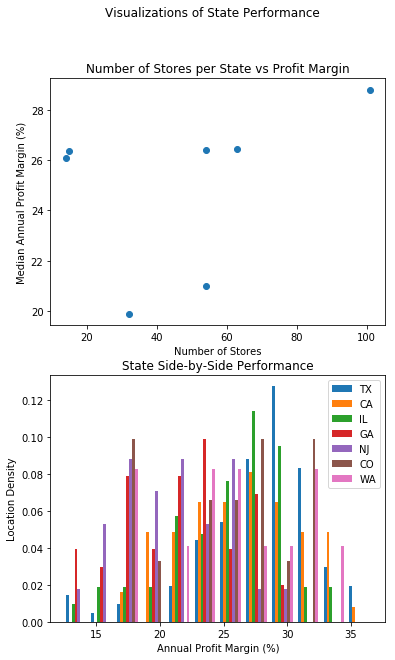

In [15]:
#Separate list for each state
x1 = list(cleaned_annual_profit[cleaned_annual_profit['State'] == 'TX']['Rent-adjusted annual profit margin'])
x2 = list(cleaned_annual_profit[cleaned_annual_profit['State'] == 'CA']['Rent-adjusted annual profit margin'])
x3 = list(cleaned_annual_profit[cleaned_annual_profit['State'] == 'IL']['Rent-adjusted annual profit margin'])
x4 = list(cleaned_annual_profit[cleaned_annual_profit['State'] == 'GA']['Rent-adjusted annual profit margin'])
x5 = list(cleaned_annual_profit[cleaned_annual_profit['State'] == 'NJ']['Rent-adjusted annual profit margin'])
x6 = list(cleaned_annual_profit[cleaned_annual_profit['State'] == 'CO']['Rent-adjusted annual profit margin'])
x7 = list(cleaned_annual_profit[cleaned_annual_profit['State'] == 'WA']['Rent-adjusted annual profit margin'])

state_values = [x1, x2, x3, x4, x5, x6, x7]
state_names = ['TX','CA','IL','GA','NJ','CO','WA']
state_data = []

for i in range(7):
    state_data.append([len(cleaned_annual_profit[cleaned_annual_profit['State'] == state_names[i]]), statistics.median(state_values[i])])

state_df = pd.DataFrame(state_data, columns = ['Number of stores','Median annual profit margin']) 

#Visualization of state performance
#Create plot
fig, axes = plt.subplots(2,1, figsize = (6,10))
#Create scatters
axes[0].scatter(state_df['Number of stores'], state_df['Median annual profit margin'])
axes[1].hist(state_values, bins = 'auto', density = True,
         label=state_names)

#Set labels
fig.suptitle('Visualizations of State Performance')
axes[0].set(xlabel='Number of Stores', ylabel='Median Annual Profit Margin (%)',title='Number of Stores per State vs Profit Margin')
axes[1].set(xlabel='Annual Profit Margin (%)', ylabel='Location Density',title='State Side-by-Side Performance',)
axes[1].legend()

#Show and save plot
plt.savefig('State Performance.png')
plt.show()

Dear CEO,

There is clearly significant variation in performance across stores nationwide. The data suggests that there is material underperformance as reflected by more stores underperforming against the mean (see distribution visualizations). Several factors may account for this underperformance. One consideration is the efficiency of store management in managing costs. The data suggests that top performing stores have lower fixed and variable cost structures. The top quintile of stores has a median fixed cost ratio of 18% versus 27% for the lowest quintile. Similarly, this top quintile has a median variable cost ratio of 49% versus 57% for the lowest quintile. Some of these costs may not be controllable (e.g. may be a function of location and labor markets), but other costs may be under the control of management and suggest some managers are doing better job managing costs.

Another consideration is location with stores in certain states performing considerably better than in other states. For example, stores located in Texas, California, Illinois, Colorado, and Washington achieved similar profitability (measured by profit margin with a mean of 26.8%) that are higher on average by 31% than stores located in Georgia and New Jersey (mean of 20.4%). This could also be a function of weather patterns and products offered in those states so it is not entirely clear whether location alone is decisive. A state by state analysis may reveal additional insight.

Number of products offered seems to factor in profitability. The top quintile stores in profitability offered on average 4635 products vs. 4350 products offered in the lowest quintile. This suggests that increasing the number of products offered may improve profitability.

One other factor I considered is whether owned locations performed better or worse than rented locations but the data does not suggest that there is signification variation.

I also looked at the number of stores within each state to explore what is the optimal number of stores (are too many stores cannibalizing sales?). While I did not adjust for population or area size, I could not reach a definitive conclusion.

Sincerely,
Owen Marks